In [1]:
# TCC: APLICAÇÃO DE MACHINE LEARNING PARA APOSTAS ESPORTIVAS: uso de Regressão Logística,
#      SVM, Árvore de Decisão e Naive Bayes
#
# Aluno: João Henrique
# Orientadora: Renata Alcoforado

In [2]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [3]:
# O arquivo utilizado foi uma compilação com dados baixados do site www.football-data.co.uk, que disponibiliza...
# ... informações de diversos campeonatos ao redor do mundo
# Por meio do Excel foram retirados os jogos em que estavam faltando dados de quaisquer variáveis de interesse...
# ...para o estudo


# Legenda das variáveis:

# Div = Divisão da Liga
# Date = Data do jogo
# HomeTeam = Time da casa
# AwayTeam = Time visitante
# FTR = Resultado do jogo (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
# B365H = Odd (probablidade) de vitória do time da casa pela Bet365 (casa de apostas)
# B365D = Odd (probablidade) de empate pela Bet365 (casa de apostas)
# B365A = Odd (probablidade) de vitória do time visitante pela Bet365 (casa de apostas)
# BWH = Odd (probablidade) de vitória do time da casa pela Bet&Win (casa de apostas)
# BWD = Odd (probablidade) de empate pela Bet&Win (casa de apostas)
# BWA = Odd (probablidade) de vitória do time visitante pela Bet&Win (casa de apostas)
# IWH = Odd (probablidade) de vitória do time da casa pela Interwetten (casa de apostas)
# IWD = Odd (probablidade) de empate pela Interwetten (casa de apostas)
# IWA = Odd (probablidade) de vitória do time visitante pela Interwetten (casa de apostas)
# PSH = Odd (probablidade) de vitória do time da casa pela Pinnacle (casa de apostas)
# PSD = Odd (probablidade) de empate pela Pinnacle (casa de apostas)
# PSA = Odd (probablidade) de vitória do time visitante pela Pinnacle (casa de apostas)
# VCH = Odd (probablidade) de vitória do time da casa pela VC Bet (casa de apostas)
# VCD = Odd (probablidade) de empate pela VC Bet (casa de apostas)
# VCA = Odd (probablidade) de vitória do time visitante pela VC Bet (casa de apostas)
# WHH = Odd (probablidade) de vitória do time da casa pela William Hill (casa de apostas)
# WHD = Odd (probablidade) de empate pela William Hill (casa de apostas)
# WHA = Odd (probablidade) de vitória do time visitante pela William Hill (casa de apostas)

# Lendo o arquivo SPA10anos.csv
data = pd.read_csv('SPA10anos.csv', delimiter = ',')

# Visualizando a base de dados:
display(data.head())

,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,SP1,18/08/12,Celta,Malaga,A,2.25,3.25,3.2,2.25,3.40,...,2.7,2.31,3.38,3.43,2.30,3.3,3.40,2.25,3.30,3.2
1,SP1,18/08/12,Mallorca,Espanol,H,2.00,3.30,3.8,2.00,3.30,...,3.2,2.00,3.56,4.17,2.00,3.5,4.10,2.05,3.25,3.8
2,SP1,18/08/12,Sevilla,Getafe,H,1.62,3.75,5.5,1.60,3.75,...,4.4,1.65,3.94,6.15,1.67,3.8,6.00,1.70,3.75,4.8
3,SP1,19/08/12,Ath Bilbao,Betis,A,1.83,3.50,4.2,1.85,3.50,...,4.0,1.89,3.77,4.41,1.87,3.7,4.33,1.91,3.50,4.0
4,SP1,19/08/12,Barcelona,Sociedad,H,1.10,9.00,26.0,1.08,10.00,...,14.0,1.10,12.00,31.00,1.10,12.0,31.00,1.07,11.00,29.0


In [4]:
# Criando a coluna com o identificador do jogo (Game_id)

data = pd.DataFrame(data)
data = data.reset_index()
data = data.rename(columns = {"index": "Game_id"})
data["Game_id"] = data.index + 1


# Alterando os resultados de string (D = empate, H = vitória do time da casa, A = vitória do time visitante), para
# int (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
for i in range(0,len(data)):
    if data["FTR"][i] == "D":
        data.at[i,"FTR"] = "0"
    if data["FTR"][i] == "H":
        data.at[i,"FTR"] = "1"
    if data["FTR"][i] == "A":
        data.at[i,"FTR"] = "2"

data["FTR"] = data["FTR"].astype(str).astype(int)

# Verificando as 5 primeiras linhas do arquivo após os primeiros ajustes
display(data.head())

,Game_id,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,1,SP1,18/08/12,Celta,Malaga,2,2.25,3.25,3.2,2.25,...,2.7,2.31,3.38,3.43,2.30,3.3,3.40,2.25,3.30,3.2
1,2,SP1,18/08/12,Mallorca,Espanol,1,2.00,3.30,3.8,2.00,...,3.2,2.00,3.56,4.17,2.00,3.5,4.10,2.05,3.25,3.8
2,3,SP1,18/08/12,Sevilla,Getafe,1,1.62,3.75,5.5,1.60,...,4.4,1.65,3.94,6.15,1.67,3.8,6.00,1.70,3.75,4.8
3,4,SP1,19/08/12,Ath Bilbao,Betis,2,1.83,3.50,4.2,1.85,...,4.0,1.89,3.77,4.41,1.87,3.7,4.33,1.91,3.50,4.0
4,5,SP1,19/08/12,Barcelona,Sociedad,1,1.10,9.00,26.0,1.08,...,14.0,1.10,12.00,31.00,1.10,12.0,31.00,1.07,11.00,29.0


Total de jogos:  3787
Total de colunas:  24
Total de jogos ganhos em casa:  1739
Total de jogos ganhos pelo visitante:  1087
Total de jogos empatados:  961
Percentual de jogos ganhos em casa: 45.92%


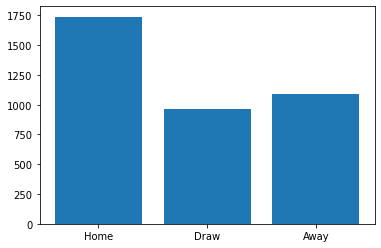

In [5]:
# Explorando a base de dados de dos campeonatos de 2012/2013 a 2021/2022 (últimas 10 temporadas completas)

# Obs.: 13 linhas da base de dados foram retiradas por falta de algumas informações necessárias de variáveis

matches = data.shape[0]
features = data.shape[1]

home_win = len(data[data.FTR==1])
away_win = len(data[data.FTR==2])
draw = len(data[data.FTR==0])
val = [home_win, draw, away_win]

win_rate = (float(home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Draw', 'Away'))
plt.show()

In [6]:
# Separando as features e as labels

features = data[['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA']]
labels = data['FTR']

print('Features')
print(features.head())
print('=====================')
print('Labels')
print(labels.head())

Features
   B365H  B365D  B365A   BWH    BWD    BWA   IWH  IWD   IWA   PSH    PSD  \
0   2.25   3.25    3.2  2.25   3.40   3.25  2.40  3.2   2.7  2.31   3.38   
1   2.00   3.30    3.8  2.00   3.30   4.10  2.10  3.2   3.2  2.00   3.56   
2   1.62   3.75    5.5  1.60   3.75   5.50  1.70  3.5   4.4  1.65   3.94   
3   1.83   3.50    4.2  1.85   3.50   4.10  1.80  3.4   4.0  1.89   3.77   
4   1.10   9.00   26.0  1.08  10.00  23.00  1.12  7.0  14.0  1.10  12.00   

     PSA   VCH   VCD    VCA   WHH    WHD   WHA  
0   3.43  2.30   3.3   3.40  2.25   3.30   3.2  
1   4.17  2.00   3.5   4.10  2.05   3.25   3.8  
2   6.15  1.67   3.8   6.00  1.70   3.75   4.8  
3   4.41  1.87   3.7   4.33  1.91   3.50   4.0  
4  31.00  1.10  12.0  31.00  1.07  11.00  29.0  
Labels
0    2
1    1
2    1
3    2
4    1
Name: FTR, dtype: int32


In [7]:
# Normalizando os dados de entrada (features)

scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('Features: ',features_scale.shape)
print(features_scale)

Features:  (3787, 18)
[[0.04923939 0.03508772 0.05310621 ... 0.04923939 0.05517241 0.04246795]
 [0.03923139 0.03859649 0.06813627 ... 0.04123299 0.05172414 0.05448718]
 [0.02401922 0.07017544 0.11072144 ... 0.02722178 0.0862069  0.07451923]
 ...
 [0.04323459 0.0877193  0.04809619 ... 0.04123299 0.09655172 0.04246795]
 [0.0592474  0.03859649 0.04483968 ... 0.0572458  0.05172414 0.03645833]
 [0.06405124 0.03859649 0.04058116 ... 0.06405124 0.04827586 0.03245192]]


In [8]:
# Separação de treino e teste, feita manualmente para manter a ordem cronológica, uma vez que...
# ... temos informação temporal.
# Treino [:3029]     representa 80% dos dados
# Teste [3029:3408]      representa 10% dos dados
# Previsão [3408:3787]     representa 10% dos dados


X_train = features_scale[:3029]
X_test = features_scale[3029:3408]
y_train = labels[:3029]
y_test = labels[3029:3408]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

3029 3029
379 379


In [9]:
# Rodando o modelo de Regressão Logística em sua versão multinomial

clf_LR = LogisticRegression(multi_class = 'multinomial', max_iter = 2000)
clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_test)

lr_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Regressão Logística')
print('')
print('Acurácia: {:.2f}%'.format(lr_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Regressão Logística

Acurácia: 53.56%
F1 Score: 53.56%


In [10]:
# Rodando o modelo de Support Vector Machine (SVM)

clf_SVM = SVC()
clf_SVM.fit(X_train, y_train)
pred = clf_SVM.predict(X_test)

svm_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('SVM')
print('')
print('Acurácia: {:.2f}%'.format(svm_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

SVM

Acurácia: 52.51%
F1 Score: 52.51%


In [11]:
# Rodando o modelo de Árvore de Decisão

clf_DT = DecisionTreeClassifier(random_state=42)
clf_DT.fit(X_train, y_train)
pred = clf_DT.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Árvore de Decisão')
print('')
print('Acurácia: {:.2f}%'.format(dt_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Árvore de Decisão

Acurácia: 41.95%
F1 Score: 40.56%


In [12]:
# Rodando o modelo de Naive Bayes

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
pred = clf_NB.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Naive Bayes')
print('')
print('Acurácia Naive Bayes: {:.2f}%'.format(nb_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Naive Bayes

Acurácia Naive Bayes: 41.16%
F1 Score: 41.16%


In [13]:
#Executando a previsão pelo método de maior acurácia (Regressão Logística)

previsao = features_scale[3408:]

game_id_full = data['Game_id']
game_id_prev = game_id_full[3408:]

res_full = data['FTR']
res_prev = res_full[3408:]

pred = clf_LR.predict(previsao)

df = pd.DataFrame({'Real': res_prev, 'Previsão': pred, 'Game_id': game_id_prev})

print(df)

      Real  Previsão  Game_id
3408     1         1     3409
3409     0         1     3410
3410     0         2     3411
3411     2         2     3412
3412     0         1     3413
...    ...       ...      ...
3782     0         1     3783
3783     2         2     3784
3784     2         1     3785
3785     1         1     3786
3786     2         1     3787

[379 rows x 3 columns]


<AxesSubplot:xlabel='Previsão', ylabel='Real'>

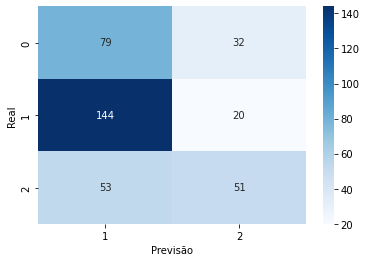

In [14]:
#confusion Matrix

df = pd.DataFrame(df,columns = ['Real','Previsão'])

cf_matrix = pd.crosstab(df['Real'], df['Previsão'], rownames = ['Real'] , colnames = ['Previsão'])

sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')